#  **Deep Fake Detection**

Image face classification with Fake and Real faces

Dataset from Kaggle [link](https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images/data?select=Dataset)

## **Importing Libraries**

Все необходимые для запуска библиотеки, а также константы (необходимо установить подходящие значения)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import models as torch_models
from torchvision.transforms import v2 as transforms

import vit_pytorch

from torchinfo import summary as info_summary

import os
import time
import json
import random
import warnings
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt


labels_map = {0: "Fake", 1: "Real"}
labels_map_reversed = dict(zip(labels_map.values(), labels_map.keys()))

# <- Enter your path
DATASET_PATH = "S://DataSet/DeepFake"
# DATASET_PATH = "D://BigDataSets/DeepFake"
# DATASET_PATH = "D://BigFiles/DataSets/DeepFake"
MODEL_DIR = "./models"

transform_base = transforms.Compose([
    transforms.ToImage(),  # transforms.ToTensor()
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

warnings.filterwarnings('ignore', category=FutureWarning)

# Debug mode
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Boost speed
USE_AMP = True
torch.backends.cudnn.benchmark = True  
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using PyTorch version: {torch.__version__}\nDevice: {device}")

Using PyTorch version: 2.5.1
Device: cuda


### Utils

Полезные для мониторинга, вывода и контроля обучения функции

In [3]:
def progress_bar(n_iter, n_total, prefix='Progress: ', suffix='', length=55, fill='█', lost='-', percent=True):
    percent = f"{100 * (n_iter / float(n_total)) :.1f}% " if percent else ""
    filled_length = round(length * n_iter // n_total)
    bar = fill * filled_length + lost * (length - filled_length)
    print(f'\r{prefix}[{n_iter}/{n_total}] |{bar}| {percent}{suffix}', end=' ' * 10)
    if n_iter == n_total:
        print()


class AddGaussianNoise:
    def __init__(self, mean=0., std=1., p=1.):
        self.std = std
        self.mean = mean
        self.p = p

    def __call__(self, tensor):
        if np.random.rand() > self.p:
            return tensor

        return tensor + (torch.randn(tensor.size()) * self.std + self.mean) * torch.randn([1])

    def __repr__(self):
        return self.__class__.__name__ + f'({self.mean = }, {self.std = })'


class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.best_loss = 1e9
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if (val_loss - self.best_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:  
                self.early_stop = True

        self.best_loss = min(val_loss, self.best_loss)
    
    def __bool__(self):
        return self.early_stop
    
class SaveOnlyBestModel:
    def __init__(self, model_ref: nn.Module, **kwargs):
        self.best_val_loss = 1e9
        self.model = model_ref
        self.kwargs = kwargs

    def step(self, val_loss):
        if (val_loss - self.best_val_loss) < 0.:
            save_model(self.model, **self.kwargs)
        self.best_val_loss = min(val_loss, self.best_val_loss)
        
class StairAccumulateGradient:
    def __init__(self, stairs_dict: dict):
        self.stairs_dict = stairs_dict
        self.current = 1
    
    def __call__(self, epoch: int):
        self.current = self.stairs_dict.get(epoch, self.current)
        return self.current
    
    
class MultiEpochsDataLoader(torch.utils.data.DataLoader):
    """persistent_workers=True analog"""
    class RepeatSampler(object):
        def __init__(self, sampler):
            self.sampler = sampler
    
        def __iter__(self):
            while True:
                yield from iter(self.sampler)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = MultiEpochsDataLoader.RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)


def save_model(model_: nn.Module, name="", only_weights=False):
    name = name if name else model_.name
    if only_weights:
        torch.save(model_.state_dict(), os.path.join(MODEL_DIR, f"{name}_weights.pth"))
    else:
        torch.save(model_, os.path.join(MODEL_DIR, f"{name}.pth"))

def load_model_weights(model_class, name="") -> nn.Module:
    name = name if name else model_class.base_name
    model_ = model_class()
    model_.load_state_dict(torch.load(os.path.join(MODEL_DIR, f"{name}_weights.pth")))
    model_.to(device).eval()
    return model_

def load_model(name: str) -> nn.Module:
    model_ = torch.load(os.path.join(MODEL_DIR, f"{name}.pth")).to(device).eval()
    return model_


def show_history(history_):
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_["train_losses"], label='Training loss')
    plt.plot(history_["val_losses"], label='Validation loss')
    plt.legend(frameon=False)
    plt.title("Loss on training")
    
    plt.subplot(1, 2, 2)
    plt.plot(history_["train_accuracy"], label='Training accuracy')
    plt.plot(history_["val_accuracy"], label='Validation accuracy')
    plt.legend(frameon=False)
    plt.title("Accuracy on training")
    plt.show()

    
def show_from_loader(loader_or_batch: torch.utils.data.DataLoader, is_show_predict=False,
                     rows=1, cols=8, augmentation=None):
    images, labels = next(iter(loader_or_batch))
    images, labels = images[:rows*cols], labels[:rows*cols]
    if augmentation:
        images = augmentation(images)

    if is_show_predict:
        _, outputs = forward_step(images, labels)
    
    # Normalize to imshow
    images -= images.min()
    images /= images.max()
    images = np.clip(images, 0, 1)
    labels = labels.numpy()
    # outputs = outputs.round(2)
    
    plt.figure(figsize=(int(2.3*cols), int(2.7*rows)))
    for i in range(cols*rows):
        plt.subplot(rows, cols, i + 1)
        image = images[i]
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        if is_show_predict:
            plt.title(f"{labels_map[labels[i]]} ({outputs[i] :.3f})",
                      c=('g' if labels[i] == round(outputs[i]) else 'r'))
        else:
            plt.title(labels_map[labels[i]])
    
    plt.show()
    print(f"Min={images.min()} Max={images.max()} Mean={images.mean()} Std={images.std()}")

## Dataset
Learn and load data

#### Make DataSet

 Создание тренировочного и валидационного загрузчика

In [14]:
def get_dataset_of_category(category: str) -> torch.utils.data.Dataset:
    return torchvision.datasets.ImageFolder(
        root=os.path.join(DATASET_PATH, category),
        transform=transform_base)


dataset_train = get_dataset_of_category("Train")
dataset_val   = get_dataset_of_category("Validation")
dataset_test  = get_dataset_of_category("Test")

load_options = {'shuffle': True,}
if str(device) == 'cuda':
    load_options |= {'drop_last': True, 'pin_memory': True,
                     'prefetch_factor': 3, 'num_workers': 8, 'persistent_workers': True}
    

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, **load_options)
loader_val   = torch.utils.data.DataLoader(dataset_val,  batch_size=256, **load_options)
loader_test  = torch.utils.data.DataLoader(dataset_test, batch_size=256, **load_options)
# loader = MultiEpochsDataLoader(dataset, ...)


print(dataset_train.class_to_idx,
      (device, load_options),
      (loader_train.pin_memory, loader_train.prefetch_factor, loader_train.num_workers),
      (len(dataset_train), len(dataset_val), len(dataset_test)),
      (loader_train.batch_size, loader_val.batch_size, loader_test.batch_size),
      sep='\n')

{'Fake': 0, 'Real': 1}
(device(type='cuda'), {'shuffle': True, 'drop_last': True, 'pin_memory': True, 'prefetch_factor': 3, 'num_workers': 8, 'persistent_workers': True})
(True, 3, 8)
(140002, 39428, 10921)
(128, 256, 256)


Min=-2.1179039478302 Max=2.640000104904175 Mean=-0.17527608573436737 Std=1.1949788331985474
torch.Size([128, 3, 256, 256]) tensor([1, 1, 0, 1, 0, 0, 1, 0, 1, 0])
(tensor([[ 1.7009,  1.8550,  2.0263,  ...,  1.6324,  1.6324,  1.6495],
        [ 1.7694,  1.9064,  2.0605,  ...,  1.7009,  1.6667,  1.6495],
        [ 1.8893,  1.9920,  2.0948,  ...,  1.6838,  1.6153,  1.5639],
        ...,
        [-1.3302, -1.3130, -1.3130,  ..., -1.9809, -1.9980, -1.9980],
        [-1.3130, -1.3130, -1.2959,  ..., -1.9809, -1.9980, -1.9980],
        [-1.2959, -1.2959, -1.2788,  ..., -1.9809, -1.9980, -2.0152]]), tensor(1))


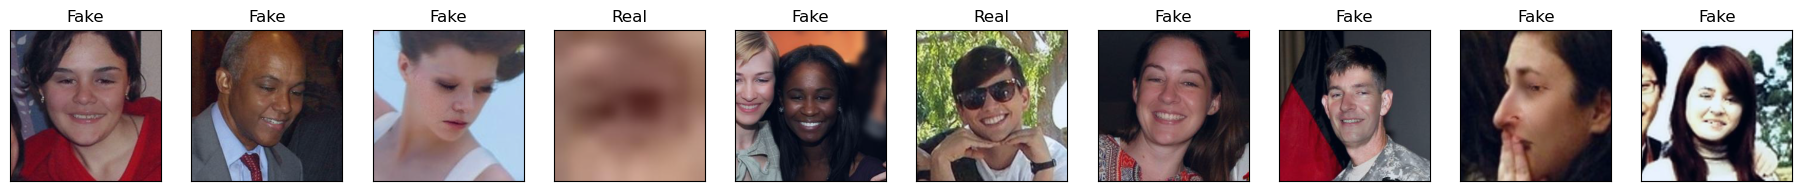

Min=0.0 Max=1.0 Mean=0.36924514174461365 Std=0.24825681746006012


In [15]:
for imgs, labels in loader_train:
    print(f"Min={imgs.min()} Max={imgs.max()} Mean={imgs.mean()} Std={imgs.std()}")
    print(imgs.shape, labels[:10])
    print((imgs[0, 0], labels[0]))
    break
    
show_from_loader(loader_train, rows=1, cols=10)

#### Augmentation for data

```
loader -> transform_base -> (transform_train_vN -> train_model) -> pred -> train
loader -> transform_base ->             predict_model           -> pred
```

In [6]:
# transforms.Resize(size=(256, 256))
# transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.35)
# transforms.ColorJitter(brightness=color_alpha, contrast=color_alpha, hue=0, saturation=color_alpha),  color_alpha = 0.22
# transforms.RandomPerspective(distortion_scale=0.2, p=0.2),

# transforms = v2.Compose([
#     v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
#     v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
#     ....................
#     v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])


transform_train_v1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])

transform_train_v2 = transforms.Compose([
    transforms.RandAugment(), transforms.RandomHorizontalFlip(p=0.5),])

transform_train_v3 = transforms.Compose([
    transforms.AugMix(), transforms.RandomHorizontalFlip(p=0.5),])

transform_train_v4 = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(p=0.5),])

transform_train_v5 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ColorJitter(brightness=0.07, contrast=0.07, hue=0.07, saturation=0.07),
    transforms.RandomRotation(degrees=7),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
])  # AddGaussianNoise(mean=0.0, std=0.05, p=0.07),

# 1) 100% Fast
# 2) 70% Mean
# 3) 30% Slooow...
# 4) 60% Mean
# 5) 15% Too very slooow...

#### Explore dataset
Наглядное сравнение разных аугментаций

In [ ]:
simple_batch = next(iter(loader_train))

show_from_loader(simple_batch, rows=1, cols=10)
show_from_loader(simple_batch, augmentation=transform_train_v1, rows=1, cols=10)
show_from_loader(simple_batch, augmentation=transform_train_v2, rows=1, cols=10)
show_from_loader(simple_batch, augmentation=transform_train_v3, rows=1, cols=10)
show_from_loader(simple_batch, augmentation=transform_train_v4, rows=1, cols=10)
show_from_loader(simple_batch, augmentation=transform_train_v5, rows=1, cols=10)

### Train cycle

In [7]:
def binary_accuracy_count(outputs, labels):
    return (np.round(outputs) == labels.numpy()).sum()


def forward_step(images, labels, augmentation=None):
    if augmentation:
        images = augmentation(images)
    images, labels = images.to(device), labels.to(device).float()
    
    with torch.autocast(device_type=str(device), dtype=torch.float16, enabled=USE_AMP):
        outputs = model(images)
        loss = loss_function(outputs, labels)
    
    return loss, F.sigmoid(outputs.data).detach().cpu().numpy()

In [8]:
def run_loader(loader: torch.utils.data.DataLoader, epoch=0, type_run="<type>",
               is_train=False, augmentation=None, options={}):
    # Metrics
    sum_loss = accuracy_count = 0
    
    # Params
    accum_grad = options.get('gradient_accumulation_steps', StairAccumulateGradient({}))(epoch)
    grad_clip = options.get('grad_clip', None)
    
    # Run
    for i, (images, labels) in enumerate(loader):
        loss, outputs = forward_step(images, labels, augmentation)
        
        # Backward propagation
        if is_train:
            loss /= accum_grad
            stat_batch_size.scale(loss).backward()
            
            if i % accum_grad == 0:
                if grad_clip is not None:  # Gradient Clip
                    stat_batch_size.unscale_(optimizer)
                    torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
                # Update scaler params
                stat_batch_size.step(optimizer)
                stat_batch_size.update()
                
                # Prevent accumulation of gradients
                optimizer.zero_grad(set_to_none=True)
            
            loss *= accum_grad

        # Metrics - Loss & Accuracy
        sum_loss += loss.item()
        correct_count = binary_accuracy_count(outputs, labels)
        accuracy_count += correct_count

        progress_bar(i, len(loader), prefix=f"Epoch {epoch} {type_run}: ",
                     suffix=f"loss: {loss.item() :.3f}\taccuracy: {correct_count / len(labels):.3f}")
    
    return sum_loss / len(loader), accuracy_count / len(loader.dataset)


def train(epochs: int, augmentation=None, callbacks={}, options={}):
    train_losses, val_losses = [], []
    train_accuracy, val_accuracy = [], []
    optimizer.zero_grad(set_to_none=True)
    
    # Epochs
    for epoch in range(1, epochs+1):
        start_time = time.time()
        
        # Model Training
        model.train(True)
        train_loss, train_accuracy_epoch = run_loader(
            loader_train, epoch=epoch, type_run='train',
            is_train=True, augmentation=augmentation, options=options
        )
    
        # Model Validation
        model.train(False)
        with torch.inference_mode():  # torch.no_grad()
            val_loss, val_accuracy_epoch = run_loader(
                loader_val, epoch=epoch, type_run='val',
                is_train=False
            )

        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        train_accuracy.append(train_accuracy_epoch)
        val_accuracy.append(val_accuracy_epoch)
        
        progress_bar(len(loader_train), len(loader_train), length=10, percent=False,
                     prefix=f"Epoch {epoch} ({time.time() - start_time :.0f} sec): ",
                     suffix=f"loss: {train_losses[-1] :.4f}\taccuracy: {train_accuracy[-1] :.3f}\t"
                            f"val_loss: {val_losses[-1] :.4f}\tval_accuracy: {val_accuracy[-1] :.3f}\t" +
                            (f"Lr (e-3): {callbacks['lr_scheduler'].optimizer.param_groups[0]['lr'] * 1e3:.2f}"
                             if callbacks.get("lr_scheduler") else ""))
        
        # Callbacks
        if "early_stopping" in callbacks:
            callbacks["early_stopping"].step(val_losses[-1])
            if callbacks["early_stopping"]:
                print("INFO: Early stopping!")
                break
        if "lr_scheduler" in callbacks:
            callbacks["lr_scheduler"].step(val_losses[-1])
        if "save_best_model" in callbacks:
            callbacks["save_best_model"].step(val_losses[-1])


    return {"train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracy": val_accuracy,
            "train_accuracy": train_accuracy,}

## Model architecture

In [9]:
class BaseModel:
    def __init__(self):
        self.name = "BaseModel"
        self.input_size = (256, 256)
        self.input_chanels = 3
        self.out_features = 1


In [10]:
class Model_SqueezeNeXt(nn.Module, BaseModel):
    # https://sh-tsang.medium.com/reading-squeezenext-hardware-aware-neural-network-design-image-classification-3fc8d1d3f76
    # https://github.com/osmr/imgclsmob/blob/c03fa67de3c9e454e9b6d35fe9cbb6b15c28fda7/pytorch/pytorchcv/models/squeezenext.py
    # https://arxiv.org/pdf/1803.10615v2.pdf
    class SqueezeNeXtUnit(nn.Module):
        def __init__(self,
                     in_channels,
                     out_channels,
                     stride):
            super().__init__()
            if stride == 2:
                reduction_den = 1
                self.resize_identity = True
            elif in_channels > out_channels:
                reduction_den = 4
                self.resize_identity = True
            else:
                reduction_den = 2
                self.resize_identity = False
                
            self.use_bias = False
            self.act = nn.ReLU(inplace=True)
            
            self.conv_x5 = nn.Sequential(
                # Conv 1 (1x1)
                nn.Conv2d(in_channels=in_channels, out_channels=(in_channels // reduction_den),
                          kernel_size=1, bias=self.use_bias, stride=stride),
                nn.BatchNorm2d(num_features=(in_channels // reduction_den)), self.act,
                # Conv 2 (1x1)
                nn.Conv2d(in_channels=(in_channels // reduction_den), out_channels=(in_channels // (2 * reduction_den)),
                          kernel_size=1, bias=self.use_bias),
                nn.BatchNorm2d(num_features=(in_channels // (2 * reduction_den))), self.act,
                # Conv 3 (1x3)
                nn.Conv2d(in_channels=(in_channels // (2 * reduction_den)), out_channels=(in_channels // reduction_den),
                          kernel_size=(1, 3), padding=(0, 1), bias=self.use_bias),
                nn.BatchNorm2d(num_features=(in_channels // reduction_den)), self.act,
                # Conv 4 (3x1)
                nn.Conv2d(in_channels=(in_channels // reduction_den), out_channels=(in_channels // reduction_den),
                          kernel_size=(3, 1), padding=(1, 0), bias=self.use_bias),
                nn.BatchNorm2d(num_features=(in_channels // reduction_den)), self.act,
                # Conv 5 (1x1)
                nn.Conv2d(in_channels=(in_channels // reduction_den), out_channels=out_channels,
                          kernel_size=1, bias=self.use_bias),
                nn.BatchNorm2d(num_features=out_channels), self.act,
            )

            if self.resize_identity:
                self.identity_conv = nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1,
                              stride=stride, bias=self.use_bias),
                    nn.BatchNorm2d(num_features=out_channels), self.act
                )
    
        def forward(self, x):
            if self.resize_identity:
                identity = self.identity_conv(x)
            else:
                identity = x
            x = self.conv_x5(x)
            x = x + identity
            return self.act(x)

    def __init__(self, name="v1",      # Name iteration of model
                 width_scale=1.,       # Wide of model
                 layers=[2, 4, 14, 1]  # From original SqNxt-23
                 ):
        # super().__init__()
        nn.Module.__init__(self)
        BaseModel.__init__(self)
        
        self.name = f"{width_scale:.1f}-SqNxt-{sum(layers)+2}_{name}"
        
        # SqNxt-23v5
        # num_classes = 3
        init_block_channels = int(64 * width_scale)
        final_block_channels = int(128 * width_scale)
        channels_per_layers = [32, 64, 128, 256]
        channels = [[int(ci * width_scale)] * li for (ci, li) in zip(channels_per_layers, layers)]
        print(self.name, [init_block_channels], *channels, [final_block_channels])
        
        # Make arch
        self.features = nn.Sequential()
        self.features.add_module("first_block", nn.Sequential(
            nn.Conv2d(3, init_block_channels, kernel_size=5, stride=2),
            nn.BatchNorm2d(init_block_channels), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
        ))
        
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module(f"unit_{j + 1}", Model_SqueezeNeXt.SqueezeNeXtUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride))
                in_channels = out_channels
            self.features.add_module(f"stage_{i + 1}", stage)
        
        self.features.add_module("final_block", nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=final_block_channels, kernel_size=1, bias=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        ))

        self.output = nn.Sequential(
            nn.Linear(in_features=final_block_channels, out_features=self.out_features),
            # nn.Sigmoid(), nn.Flatten(start_dim=0),  # Add for binary classification by me (CE -> BCE loss)
            nn.Flatten(start_dim=0),  # Because Loss is BCE+Logits (for correct work AMP)
        )

    def forward(self, x):
        # x - must be normalized (mean=0, std=1)
        # x = transform_model_forward(x)
        x = self.features(x)
        x = self.output(x)
        return x


In [11]:
class Model_ResNet(nn.Module, BaseModel):
    def __init__(self, name="v1", is_pretrained=False, freeze_grad=False):
        # super().__init__()
        nn.Module.__init__(self)
        BaseModel.__init__(self)
        
        self.name = f"ResNet-34{'pre' if is_pretrained else ''}_{name}"
        
        # resnet18 resnet34 resnet50 resnet101
        self._pretrain_model = torch_models.resnet34(pretrained=is_pretrained)
        self._pretrain_model.requires_grad_(not freeze_grad)
        
        layers = list(self._pretrain_model.children())[:-1]
        layers.append(nn.Flatten())
        
        self.features = nn.Sequential(*layers)
        
        self.output = nn.Sequential(
            nn.Linear(
                in_features=self._pretrain_model.fc.in_features,
                out_features=self.out_features),
            nn.Flatten(start_dim=0)
        )

    def forward(self, x):  # x - must be normalized (mean=0, std=1)
        x = self.features(x)
        x = self.output(x)
        return x


In [12]:
class Model_ViT(nn.Module, BaseModel):
    def __init__(self, name="v1"):
        # super().__init__()
        nn.Module.__init__(self)
        BaseModel.__init__(self)
        
        # dim, m_dim = 1024, 2048
        # depth, heads = 6, 16
        dim, m_dim = 512, 1024
        depth, heads = 4, 12
        
        self.name = f"ViT-{depth}-{heads}-{dim}-{m_dim}_{name}"
        
        self.model = vit_pytorch.SimpleViT(
            image_size = 256,
            patch_size = 32,
            num_classes = 1,
            depth = depth,
            heads = heads,
            dim = dim,
            mlp_dim = m_dim,
            # dropout = 0.1,
            # emb_dropout = 0.1
        )
        # SimpleViT no dropout
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim=0)
        )

    def forward(self, x):  # x - must be normalized (mean=0, std=1)
        x = self.model(x)
        x = self.output(x)
        return x


## Training model

In [13]:
# Model
model = Model_SqueezeNeXt(
    name="v1",
    width_scale=1.2,      # 1.0
    layers=[6, 7, 5, 0]   # [2, 4, 14, 1]
)

# model = Model_ResNet(
#     name="v1",
#     is_pretrained=True,
#     freeze_grad=False
# )

# model = Model_ViT(name="nogit")
# model = load_model("1.0-SqNxt-17")

model.to(device)


# Summary model
with torch.autocast(device_type=str(device), dtype=torch.float16, enabled=USE_AMP):
    print(str(info_summary(model, input_size=(loader_train.batch_size, 3, 256, 256),
                           depth=3, device=device, mode="train",  # col_width=20 depth=5
                           col_names=["num_params", "mult_adds", "output_size"], row_settings=["var_names"])))


# Define our loss function
loss_function = nn.BCEWithLogitsLoss()  # nn.BCELoss()  # nn.CrossEntropyLoss()


# Define the optimizer
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # Adam RMSprop Adafactor


# AMP (Auto Mixed Precision)
stat_batch_size = torch.amp.GradScaler(device=device, enabled=USE_AMP)

# Callbacks & Schedulers
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.7, min_lr=3e-5)
early_stopping = EarlyStopping(tolerance=11, min_delta=0.)
save_best_model = SaveOnlyBestModel(model)
callbacks = {
    "lr_scheduler": lr_scheduler,
    "early_stopping": early_stopping,
    "save_best_model": save_best_model,
}

# Options
options = {
    "gradient_accumulation_steps": StairAccumulateGradient({1:2, 2:3, 5:4, 10:5, 16:6}),
    # "gradient_accumulation_steps": StairAccumulateGradient({1:1, 2:2, 5:3, 10:4, 16:5}),
    "grad_clip": None,  # Not improve (0.1)  -  grad_clip_value
}

1.2-SqNxt-20_v1 [76] [38, 38, 38, 38, 38, 38] [76, 76, 76, 76, 76, 76, 76] [153, 153, 153, 153, 153] [] [153]
Layer (type (var_name))                            Param #                   Mult-Adds                 Output Shape
Model_SqueezeNeXt (Model_SqueezeNeXt)              --                        --                        [64]
├─Sequential (features)                            --                        --                        [64, 153]
│    └─Sequential (first_block)                    --                        --                        [64, 76, 63, 63]
│    │    └─Conv2d (0)                             5,776                     5,868,785,664             [64, 76, 126, 126]
│    │    └─BatchNorm2d (1)                        152                       9,728                     [64, 76, 126, 126]
│    │    └─ReLU (2)                               --                        --                        [64, 76, 126, 126]
│    │    └─MaxPool2d (3)                          --              

In [ ]:
print(model.name)

history = train(epochs=100, augmentation=transform_train_v1, callbacks=callbacks, options=options)
show_history(history)

1.0-SqNxt-15_v1
Epoch 1 (258 sec): [546/546] |██████████| loss: 0.5445	accuracy: 0.706	val_loss: 0.4056	val_accuracy: 0.812	Lr (e-3): 1.00          
Epoch 2 (255 sec): [546/546] |██████████| loss: 0.2395	accuracy: 0.898	val_loss: 0.4983	val_accuracy: 0.806	Lr (e-3): 1.00          
Epoch 3 (193 sec): [546/546] |██████████| loss: 0.1635	accuracy: 0.932	val_loss: 0.2146	val_accuracy: 0.914	Lr (e-3): 1.00          
Epoch 4 (188 sec): [546/546] |██████████| loss: 0.1281	accuracy: 0.947	val_loss: 0.2200	val_accuracy: 0.911	Lr (e-3): 1.00          
Epoch 5 (188 sec): [546/546] |██████████| loss: 0.0970	accuracy: 0.960	val_loss: 0.1841	val_accuracy: 0.928	Lr (e-3): 1.00          
Epoch 6 (193 sec): [546/546] |██████████| loss: 0.0871	accuracy: 0.963	val_loss: 0.1607	val_accuracy: 0.938	Lr (e-3): 1.00          
Epoch 7 (235 sec): [546/546] |██████████| loss: 0.0816	accuracy: 0.966	val_loss: 0.2300	val_accuracy: 0.916	Lr (e-3): 1.00          
Epoch 8 (195 sec): [546/546] |██████████| loss: 0.077

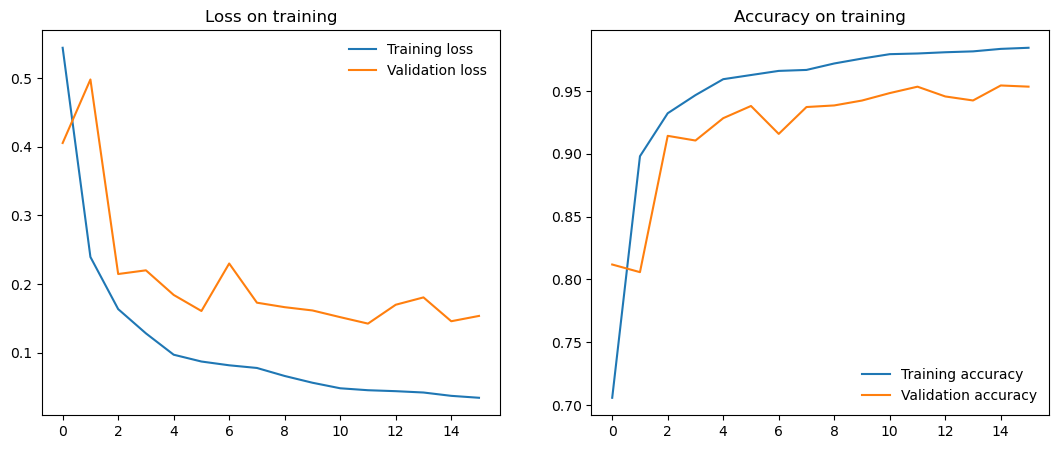

In [44]:
print(model.name)

history = train(epochs=100, augmentation=transform_train_v1, callbacks=callbacks, options=options)
show_history(history)

Epoch 1 (532 sec): [2187/2187] |██████████| loss: 0.4425	accuracy: 0.770	val_loss: 0.3558	val_accuracy: 0.854	Lr (e-3): 1.00          
Epoch 2 (497 sec): [2187/2187] |██████████| loss: 0.1791	accuracy: 0.929	val_loss: 0.2158	val_accuracy: 0.916	Lr (e-3): 1.00          
Epoch 3 (490 sec): [2187/2187] |██████████| loss: 0.1196	accuracy: 0.952	val_loss: 0.1929	val_accuracy: 0.922	Lr (e-3): 1.00          
Epoch 4 (495 sec): [2187/2187] |██████████| loss: 0.1037	accuracy: 0.959	val_loss: 0.1740	val_accuracy: 0.937	Lr (e-3): 1.00          
Epoch 5 (492 sec): [2187/2187] |██████████| loss: 0.0920	accuracy: 0.963	val_loss: 0.1574	val_accuracy: 0.937	Lr (e-3): 1.00          
Epoch 6 (491 sec): [2187/2187] |██████████| loss: 0.0838	accuracy: 0.966	val_loss: 0.1521	val_accuracy: 0.943	Lr (e-3): 1.00          
Epoch 7 (493 sec): [2187/2187] |██████████| loss: 0.0794	accuracy: 0.968	val_loss: 0.1307	val_accuracy: 0.947	Lr (e-3): 1.00          
Epoch 8 (483 sec): [2187/2187] |██████████| loss: 0.072

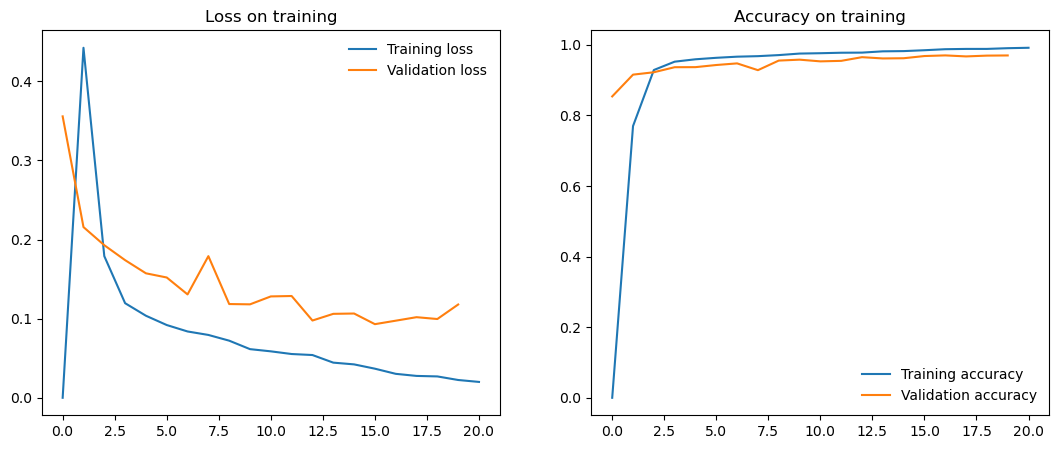

In [22]:
print(model.name)

history = train(epochs=100, augmentation=transform_train_v1, callbacks=callbacks, options=options)
show_history(history)

## Test model

In [16]:
def test_model(loader: torch.utils.data.DataLoader, augmentation=None, show=True):
    """:returns (y_true, y_pred), loss, accuracy, class_report, auc_score"""
    start_time = time.time()
    
    b_size = loader.batch_size
    y_true = np.zeros((len(loader) * b_size),)
    y_pred = np.zeros((len(loader) * b_size),)
    
    with torch.inference_mode():
        # loss, accuracy = run_loader(loader, type_run='test', is_train=False, augmentation=augmentation)
        
        # Metrics
        sum_loss = accuracy_count = 0
        
        # Run
        for i, (images, labels) in enumerate(loader):
            loss, outputs = forward_step(images, labels, augmentation)
            
            y_true[b_size * i:b_size * (i + 1)] = labels.numpy()
            y_pred[b_size * i:b_size * (i + 1)] = outputs

            # Metrics - Loss & Accuracy
            sum_loss += loss.item()
            correct_count = binary_accuracy_count(outputs, labels)
            accuracy_count += correct_count
    
            progress_bar(i, len(loader), prefix=f"Testing ({time.time() - start_time :.1f} sec): \t",
                         suffix=f" \tloss: {loss.item() :.3f} \taccuracy: {correct_count / len(labels):.3f}")
    
    loss, accuracy = sum_loss / len(loader), accuracy_count / len(loader.dataset)
    progress_bar(len(loader), len(loader), length=10, percent=False,
                 prefix=f"Testing ({time.time() - start_time :.1f} sec): \t",
                 suffix=f" \tloss: {loss :.5f} \taccuracy: {accuracy :.4f}" + " " * 40)
    
    class_report = show_metrics(y_true, y_pred, show=show)
    auc_score = show_roc_auc(y_true, y_pred, show=show)
    
    return (y_true, y_pred), loss, accuracy, class_report, auc_score

def show_metrics(y_true, y_pred, show=True):
    y_pred_one_hot = np.round(y_pred)
    labels = list(labels_map_reversed.keys())
    
    conf_matrix = metrics.confusion_matrix(y_true, y_pred_one_hot)
    class_report = metrics.classification_report(y_true, y_pred_one_hot, target_names=labels, output_dict=True)
    if show:
        print(metrics.classification_report(y_true, y_pred_one_hot, digits=4, target_names=labels))
        metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels).plot()
        plt.title(f'Confusion Matrix {model.name}')
        plt.show()
    return class_report

def show_roc_auc(y_true, y_pred, show=True):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    if show:
        plt.title(f'ROC AUC {model.name}')
        plt.plot(fpr, tpr, label=f"Auc = {auc_score*100 :.2f}")
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.03, 1.03])
        plt.ylim([-0.03, 1.03])
        plt.legend(loc=4)
        plt.grid(True)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    return auc_score

Testing (42.7 sec): 	[42/42] |██████████|  	loss: 0.29526 	accuracy: 0.9034                                                          
              precision    recall  f1-score   support

        Fake     0.8835    0.9637    0.9218      5421
        Real     0.9593    0.8708    0.9129      5331

    accuracy                         0.9176     10752
   macro avg     0.9214    0.9172    0.9174     10752
weighted avg     0.9211    0.9176    0.9174     10752



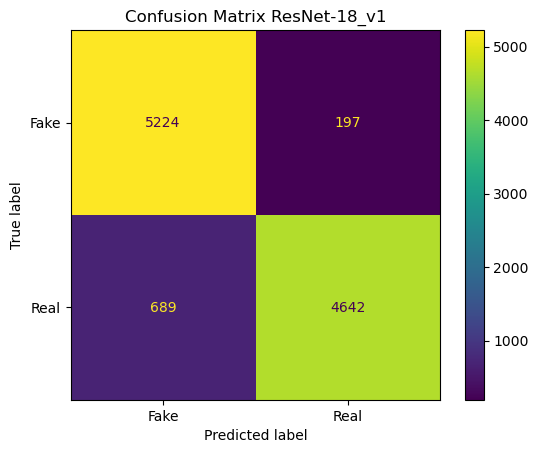

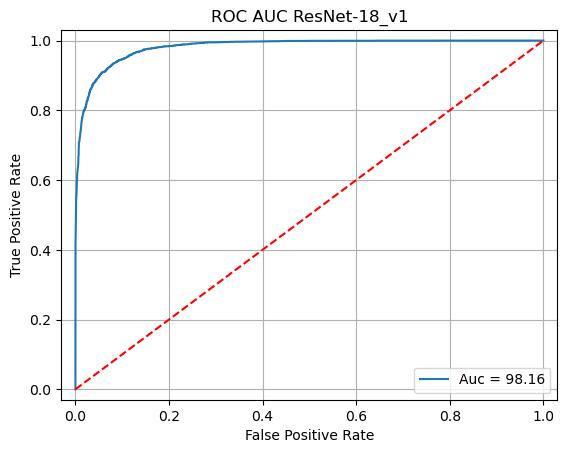

In [17]:
model = load_model("ResNet-18")

# _ = test_model(loader_val)
_ = test_model(loader_test)

In [16]:
with open(os.path.join(MODEL_DIR, "stat.json")) as file:
    statistic = json.load(file)
    # print(statistic)

table_stats = {"model": [], "loss": [], "accuracy": [], "f1": [], "auc": [],
               "val_loss": [], "val_accuracy": [], "val_f1": [], "val_auc": [],
               "params": [], "params_mb": [], "mult_ads_gflops": [], "pass_size_mb": [], "total_pass_size_mb": [],
               "test_batch_size": []}

for filename in os.listdir(MODEL_DIR):
    print(filename)
    if filename.endswith(".pth") :#and filename not in statistic: # and filename not in statistic:
        model = load_model(filename[:-4])
        
        _, test_loss, test_accuracy, test_class_report, test_auc = test_model(loader_test, show=False)
        _, val_loss, val_accuracy, val_class_report, val_auc = test_model(loader_val, show=False)
        
        stat_batch_size = 128
        with torch.autocast(device_type=str(device), dtype=torch.float16, enabled=USE_AMP):
            info = info_summary(model, input_size=(stat_batch_size, 3, 256, 256), depth=3, device=device, mode="train",
                                col_names=["num_params", "mult_adds", "output_size"], row_settings=["var_names"])
        
        info_file = {
            "Loss":                round(test_loss, 5),
            "Accuracy":            round(test_accuracy * 100, 3),
            "F1-score":            round(test_class_report['weighted avg']['f1-score'], 5),
            "AUC-score":           round(test_auc, 5),
            "Val loss":            round(val_loss, 5),
            "Val accuracy":        round(val_accuracy * 100, 3),
            "Val F1-score":        round(val_class_report['weighted avg']['f1-score'], 5),
            "Val AUC-score":       round(val_auc, 5),
            f"Structure (bs={stat_batch_size})": 
            {
                "Params": info.total_params,
                "Mult-adds GFlops": round(info.total_mult_adds / 1024 ** 3, 1),
                "Params (MB)": round(info.total_param_bytes / 1024 ** 2, 2),
                "Forward/backward pass size (MB)": round(info.total_output_bytes / 1024 ** 2, 1),
                "Estimated Total Size (MB)":
                    round((info.total_output_bytes + info.total_input + info.total_param_bytes) / 1024 ** 2, 1),
            }
        }
        table_stats["model"].append(filename)
        table_stats["loss"].append(info_file["Loss"])
        table_stats["accuracy"].append(info_file["Accuracy"])
        table_stats["f1"].append(info_file["F1-score"])
        table_stats["auc"].append(info_file["AUC-score"])
        table_stats["val_loss"].append(info_file["Val loss"])
        table_stats["val_accuracy"].append(info_file["Val accuracy"])
        table_stats["val_f1"].append(info_file["Val F1-score"])
        table_stats["val_auc"].append(info_file["Val AUC-score"])
        struct_model = info_file[f"Structure (bs={stat_batch_size})"]
        table_stats["params"].append(struct_model["Params"])
        table_stats["params_mb"].append(struct_model["Params (MB)"])
        table_stats["mult_ads_gflops"].append(struct_model["Mult-adds GFlops"])
        table_stats["pass_size_mb"].append(struct_model["Forward/backward pass size (MB)"])
        table_stats["total_pass_size_mb"].append(struct_model["Estimated Total Size (MB)"])
        table_stats["test_batch_size"].append(stat_batch_size)

        statistic[filename] = info_file

        with open(os.path.join(MODEL_DIR, "stat.json"), 'w') as file:
            json.dump(dict(sorted(statistic.items())), file, indent=4)

df = pd.DataFrame.from_dict(table_stats)
df.to_csv(os.path.join(MODEL_DIR, "stat.csv"), index=False, encoding='utf-8')

0.8-SqNxt-17.pth
Testing (8.6 sec): 	[42/42] |██████████|  	loss: 0.35750 	accuracy: 0.8518                                                          
Testing (64.0 sec): 	[154/154] |██████████|  	loss: 0.15500 	accuracy: 0.9427                                                          
1.0-SqNxt-15.pth
Testing (7.7 sec): 	[42/42] |██████████|  	loss: 0.43043 	accuracy: 0.8493                                                          
Testing (25.5 sec): 	[154/154] |██████████|  	loss: 0.14233 	accuracy: 0.9535                                                          
1.0-SqNxt-17.pth
Testing (7.8 sec): 	[42/42] |██████████|  	loss: 0.52064 	accuracy: 0.8550                                                          
Testing (25.2 sec): 	[154/154] |██████████|  	loss: 0.09656 	accuracy: 0.9661                                                          
1.2-SqNxt-20.pth
Testing (8.1 sec): 	[42/42] |██████████|  	loss: 0.46883 	accuracy: 0.8639                                                   

In [17]:
df = pd.read_csv(os.path.join(MODEL_DIR, "stat.csv"), index_col=0)
df[["accuracy", "val_accuracy"]] /= 100
df

loss  accuracy       f1      auc  val_loss  \
model                                                                        
0.8-SqNxt-17.pth             0.35750   0.85185  0.86494  0.94790   0.15500   
1.0-SqNxt-15.pth             0.43043   0.84928  0.86202  0.95032   0.14233   
1.0-SqNxt-17.pth             0.52064   0.85505  0.86738  0.95521   0.09656   
1.2-SqNxt-20.pth             0.46883   0.86393  0.87689  0.95977   0.12763   
1.4-SqNxt-18.pth             0.51017   0.84525  0.85708  0.95227   0.11148   
2.6-SqNxt-20.pth             0.58686   0.87776  0.89114  0.94616   0.09308   
ResNet-18.pth                0.29705   0.90312  0.91712  0.98142   0.08534   
ResNet-18pre.pth             0.29383   0.88939  0.90325  0.96315   0.08218   
ResNet-34pre_nogit.pth       0.46238   0.87199  0.88460  0.97266   0.05314   
ResNet-50pre_nogit.pth       0.51507   0.87135  0.88422  0.95932   0.05762   
ResNet-50_nogit.pth          0.29958   0.89900  0.91287  0.97842   0.07499   
ViT-4-12-512-1024_nogit.pth  0.55986   0.69527  0.70619  0.78240   0.52846   

                             val_accuracy   val_f1  val_auc    params  \
model                                                                   
0.8-SqNxt-17.pth                  0.94271  0.94279  0.98661    348022   
1.0-SqNxt-15.pth                  0.95354  0.95362  0.98989    276433   
1.0-SqNxt-17.pth                  0.96606  0.96616  0.99490    288481   
1.2-SqNxt-20.pth                  0.96107  0.96116  0.99230    474593   
1.4-SqNxt-18.pth                  0.96051  0.96061  0.99358   1536162   
2.6-SqNxt-20.pth                  0.96825  0.96834  0.99555   5546447   
ResNet-18.pth                     0.97324  0.97334  0.99639  11690025   
ResNet-18pre.pth                  0.96924  0.96931  0.99742  11690025   
ResNet-34pre_nogit.pth            0.98214  0.98224  0.99826  21798185   
ResNet-50pre_nogit.pth            0.97844  0.97854  0.99793  25559081   
ResNet-50_nogit.pth               0.97522  0.97532  0.99676  25559081   
ViT-4-12-512-1024_nogit.pth       0.73220  0.73206  0.81186  12082177   

                             params_mb  mult_ads_gflops  pass_size_mb  \
model                                                                   
0.8-SqNxt-17.pth                  0.95             18.6        3351.6   
1.0-SqNxt-15.pth                  0.91             25.7        3824.6   
1.0-SqNxt-17.pth                  0.95             27.9        4341.7   
1.2-SqNxt-20.pth                  1.60             41.9        5864.3   
1.4-SqNxt-18.pth                  4.72             50.7        5192.1   
2.6-SqNxt-20.pth                 17.23            170.7       10806.3   
ResNet-18.pth                    42.64            282.4        3168.0   
ResNet-18pre.pth                 42.64            282.4        3168.0   
ResNet-34pre_nogit.pth           81.20            570.4        4768.0   
ResNet-50pre_nogit.pth           89.68            636.4       14176.0   
ResNet-50_nogit.pth              89.68            636.4       14176.0   
ViT-4-12-512-1024_nogit.pth      46.09              1.4        1072.0   

                             total_pass_size_mb  test_batch_size  
model                                                             
0.8-SqNxt-17.pth                         3448.5              128  
1.0-SqNxt-15.pth                         3921.5              128  
1.0-SqNxt-17.pth                         4438.7              128  
1.2-SqNxt-20.pth                         5961.9              128  
1.4-SqNxt-18.pth                         5292.8              128  
2.6-SqNxt-20.pth                        10919.5              128  
ResNet-18.pth                            3306.6              128  
ResNet-18pre.pth                         3306.6              128  
ResNet-34pre_nogit.pth                   4945.2              128  
ResNet-50pre_nogit.pth                  14361.7              128  
ResNet-50_nogit.pth                     14361.7              128  
ViT-4-12-512-1024_nogi

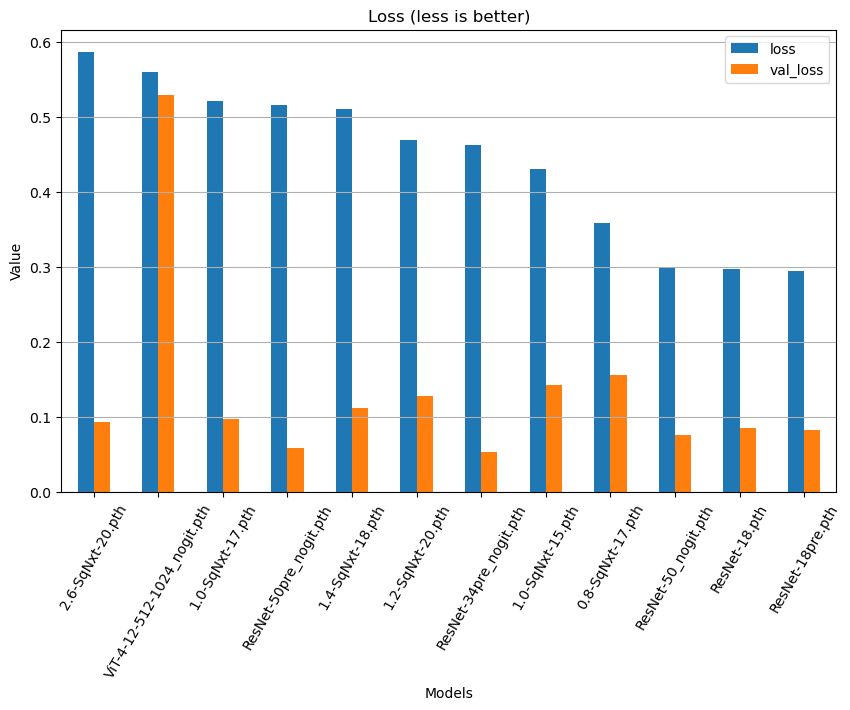

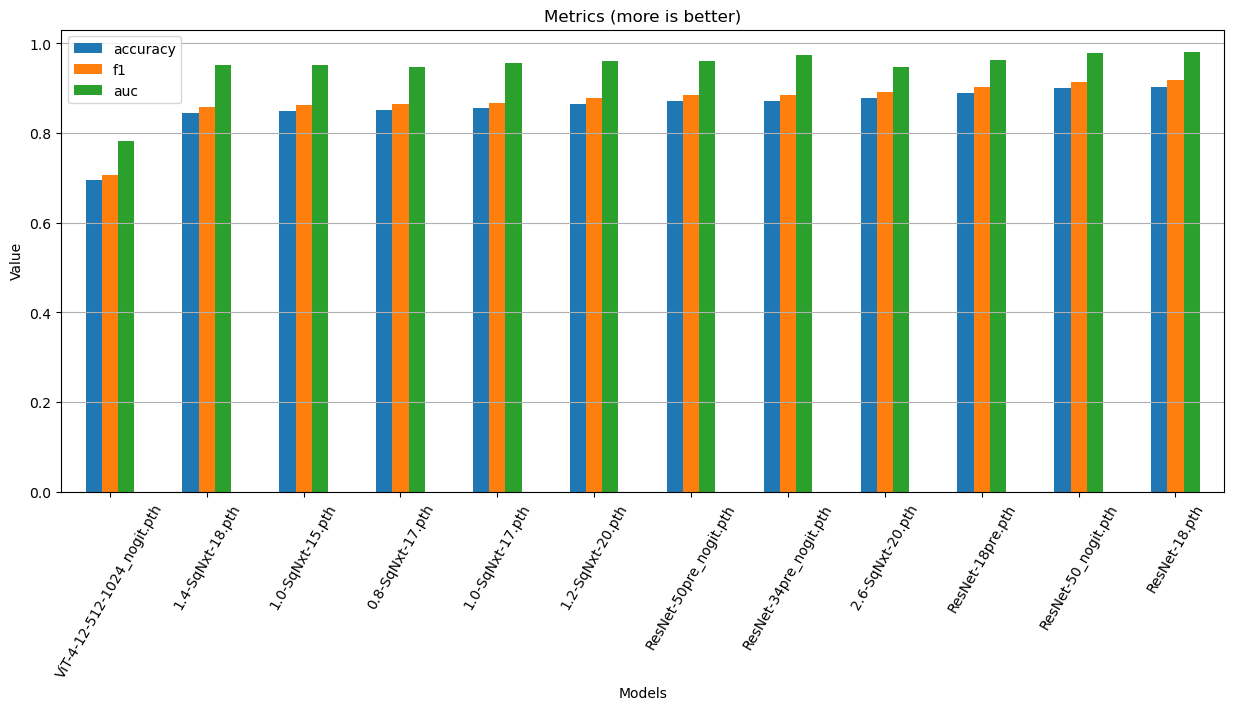

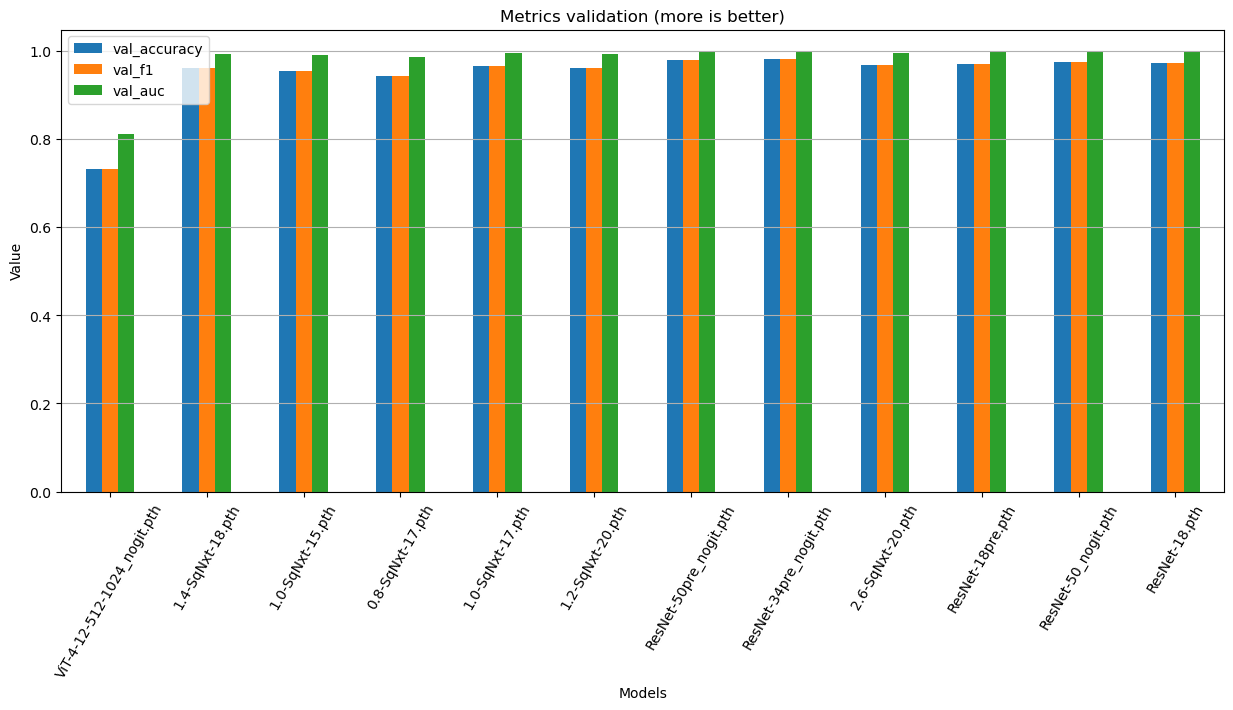

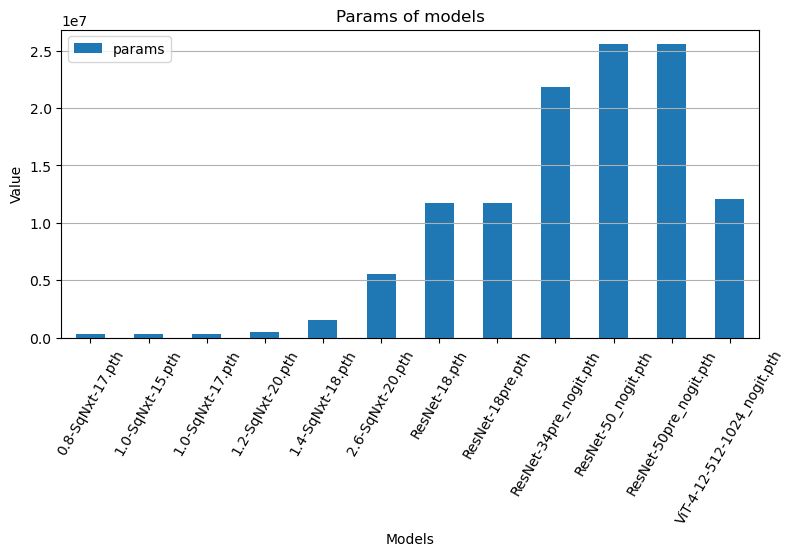

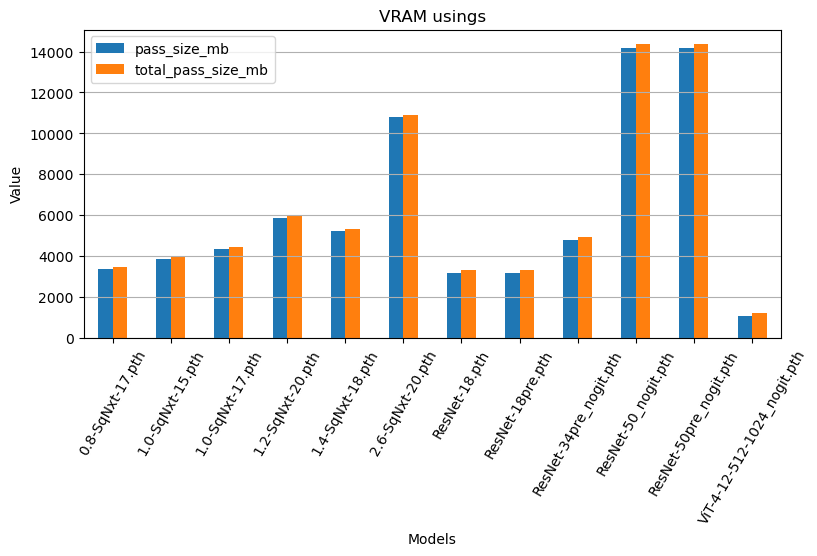

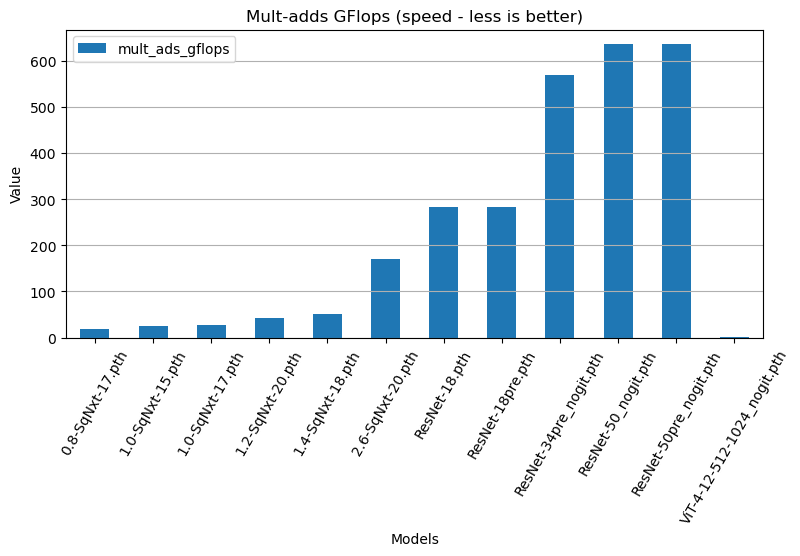

In [18]:
def show_bar_plot(title: str):
    plt.title(title)
    plt.xlabel("Models")
    plt.ylabel("Value")
    plt.grid(axis="y")
    plt.show()


labels_rot = 60

# Loss
df.sort_values(by=["loss"], ascending=False, inplace=True)  # df.sort_index(inplace=True)
df[["loss", "val_loss"]].plot.bar(rot=labels_rot, figsize=(10, 6))
show_bar_plot("Loss (less is better)")

# Test Metric
df.sort_values(by=["accuracy"], ascending=True, inplace=True)  # df.sort_index(inplace=True)
df[["accuracy", "f1", "auc"]].plot.bar(rot=labels_rot, figsize=(15, 6))
show_bar_plot("Metrics (more is better)")

# Val Metric
df[["val_accuracy", "val_f1", "val_auc"]].plot.bar(rot=labels_rot, figsize=(15, 6))
show_bar_plot("Metrics validation (more is better)")

# Param
df.sort_index(inplace=True)
df[["params"]].plot.bar(rot=labels_rot, figsize=(9, 4))
show_bar_plot("Params of models")

# VRAM
df[["pass_size_mb", "total_pass_size_mb"]].plot.bar(rot=labels_rot, figsize=(9, 4))
show_bar_plot("VRAM usings")

# Computations speed
df[["mult_ads_gflops"]].plot.bar(rot=labels_rot, figsize=(9, 4))
show_bar_plot("Mult-adds GFlops (speed - less is better)")

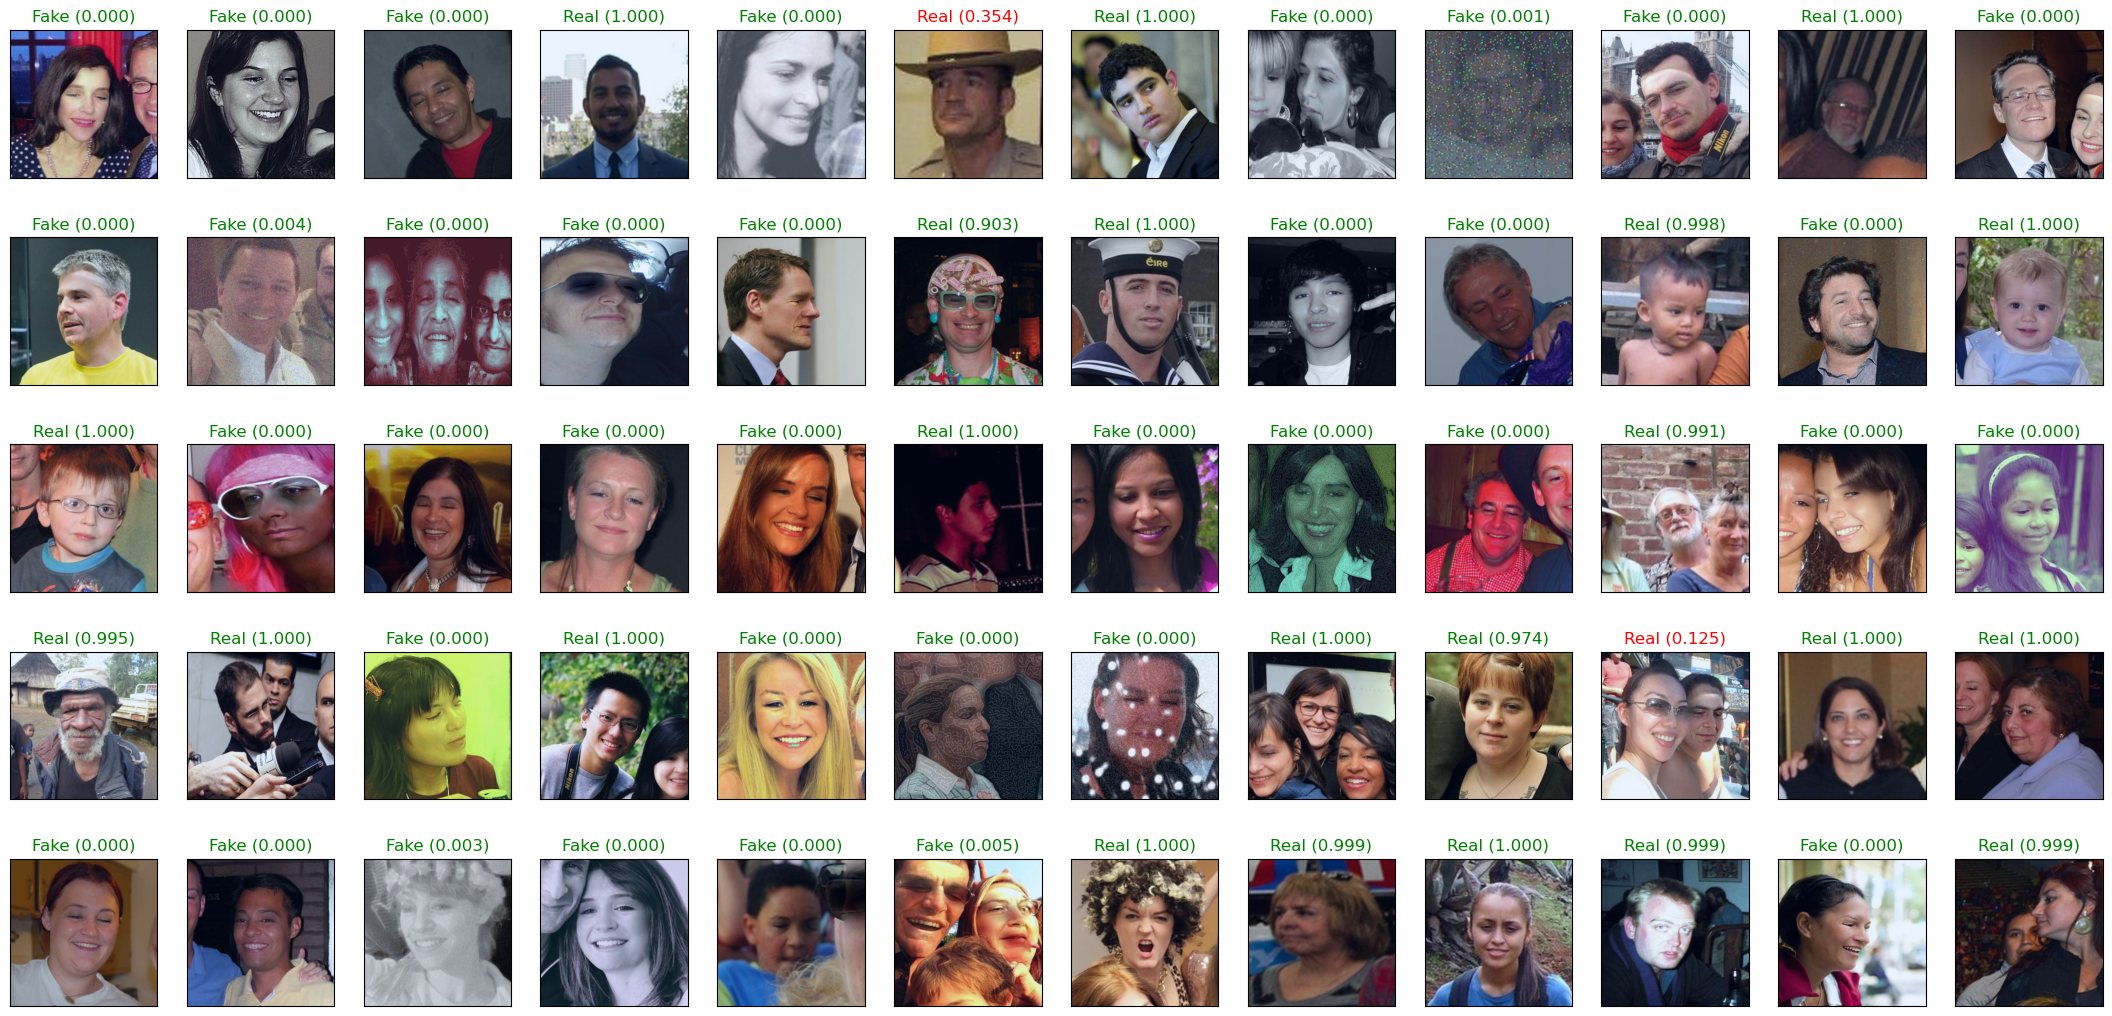

Min=0.0 Max=1.0 Mean=0.3857888877391815 Std=0.24290801584720612


In [16]:
model = load_model("ResNet-18")
show_from_loader(loader_val, rows=5, cols=12, is_show_predict=True)

## Production

Использование модели в рабочем режиме

Модель берет изображения из `TEST_IMGS_DIR` а предсказание модели помещает в файл `prediction.csv`

In [17]:
TEST_IMGS_DIR = "example/imgs/1"
TEST_DIR = "example"

model = load_model("ResNet-18")

# Loader
dataset_end_test = torchvision.datasets.ImageFolder(
    root=os.path.split(TEST_IMGS_DIR)[0],
    transform=transforms.Compose([transform_base, transforms.Resize((256, 256)),]))
loader_end_test = torch.utils.data.DataLoader(dataset_end_test, batch_size=128, shuffle=False, drop_last=False, pin_memory=True,)

print(sorted(os.listdir(TEST_IMGS_DIR)))
print(len(loader_end_test.dataset))

['fake_8379.jpg', 'fake_8380.jpg', 'fake_8381.jpg', 'fake_8382.jpg', 'fake_8383.jpg', 'fake_8384.jpg', 'fake_8385.jpg', 'fake_8386.jpg', 'fake_8387.jpg', 'fake_8388.jpg', 'fake_8389.jpg', 'fake_8390.jpg', 'fake_8391.jpg', 'fake_8392.jpg', 'fake_8393.jpg', 'fake_8394.jpg', 'fake_8395.jpg', 'fake_8396.jpg', 'fake_8397.jpg', 'fake_8398.jpg', 'fake_8399.jpg', 'fake_8400.jpg', 'fake_8401.jpg', 'fake_8402.jpg', 'fake_8403.jpg', 'fake_8404.jpg', 'fake_8405.jpg', 'fake_8406.jpg', 'fake_8407.jpg', 'fake_8408.jpg', 'fake_8409.jpg', 'fake_8410.jpg', 'fake_8411.jpg', 'fake_8412.jpg', 'fake_8413.jpg', 'fake_8414.jpg', 'fake_8415.jpg', 'fake_8416.jpg', 'fake_8417.jpg', 'fake_8418.jpg', 'fake_8419.jpg', 'fake_8420.jpg', 'fake_8421.jpg', 'fake_8422.jpg', 'fake_8423.jpg', 'fake_8424.jpg', 'fake_8425.jpg', 'fake_8426.jpg', 'fake_8427.jpg', 'fake_8428.jpg', 'fake_8429.jpg', 'fake_8430.jpg', 'fake_8431.jpg', 'fake_8432.jpg', 'fake_8433.jpg', 'fake_8434.jpg', 'fake_8435.jpg', 'fake_8436.jpg', 'fake_8437.jp

In [24]:
# # Rename
# fnames_history = {}
# filenames = os.listdir(TEST_IMGS_DIR)
# for i, name in zip(random.sample(range(len(filenames)), len(filenames)), sorted(filenames)):
#     os.rename(f"{TEST_IMGS_DIR}/{name}", f"{TEST_IMGS_DIR}/img_{i}.jpg")
#     fnames_history[f"img_{i}.jpg"] = name
# 
# for i in range(len(fnames_history)):
#     print(i, fnames_history[f"img_{i}.jpg"])

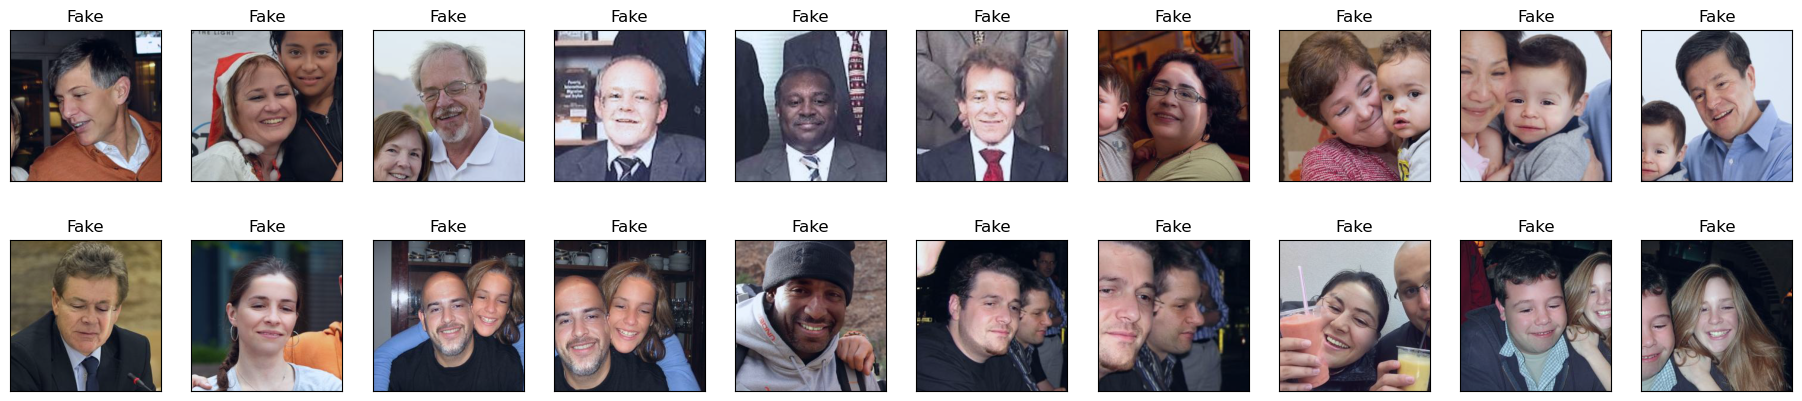

Min=0.0 Max=1.0 Mean=0.4136466383934021 Std=0.2551622688770294


In [18]:
show_from_loader(loader_end_test, rows=2, cols=10)

In [19]:
y_pred = np.zeros((len(loader_end_test.dataset)),)
start_idx = 0

with torch.inference_mode():
    for i, (images, labels) in enumerate(loader_end_test):
        _, outputs = forward_step(images, labels)
        y_pred[start_idx:start_idx+len(outputs)] = outputs
        start_idx += len(outputs)

print(y_pred.shape, y_pred.dtype)

df_res = pd.DataFrame.from_dict({
    "filename": sorted(os.listdir('example/imgs/1')),
    "pred": y_pred.round().astype(int),
    "value": y_pred.round(5)
})

df_res.to_csv(os.path.join(TEST_DIR, 'prediction.csv'), index=False, encoding='utf-8')

(360,) float64


In [28]:
# # Rename back
# for name, old_name in fnames_history.items():
#     os.rename(f"{TEST_IMGS_DIR}/{name}", f"{TEST_IMGS_DIR}/{old_name}")

In [20]:
df_res

filename  pred    value
0    fake_8379.jpg     0  0.00000
1    fake_8380.jpg     0  0.00000
2    fake_8381.jpg     0  0.00008
3    fake_8382.jpg     0  0.00000
4    fake_8383.jpg     0  0.02104
..             ...   ...      ...
355   real_553.jpg     1  1.00000
356   real_554.jpg     1  0.99854
357   real_555.jpg     1  1.00000
358   real_556.jpg     1  1.00000
359   real_557.jpg     1  1.00000

[360 rows x 3 columns]

In [18]:
2 + 2

4